# Linear regression 

In this exercise you will use linear regression to predict flat prices. One more time, training will be handled via gradient descent. Although, contratry to the first exercise, we will now:
* have multiple features (i.e. variables used to make the prediction),
* employ some basic feature engineering,
* work with a different loss function.

Let's start with getting the data.

In [ ]:
%matplotlib inline

!wget -O mieszkania.csv https://www.dropbox.com/s/zey0gx91pna8irj/mieszkania.csv?dl=1
!wget -O mieszkania_test.csv https://www.dropbox.com/s/dbrj6sbxb4ayqjz/mieszkania_test.csv?dl=1

--2021-03-19 07:52:37--  https://www.dropbox.com/s/zey0gx91pna8irj/mieszkania.csv?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/zey0gx91pna8irj/mieszkania.csv [following]
--2021-03-19 07:52:37--  https://www.dropbox.com/s/dl/zey0gx91pna8irj/mieszkania.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc1a4ba48f21b7dbbeca68538a5b.dl.dropboxusercontent.com/cd/0/get/BK_uoPPJgz8P7bnC770ExvyN5HMJG4MPccgjjhkld3AvRtIzANr2Gi7DJNPOSbhpcKhnUTdwnDdjko0OusGCccSx1dXbYQHF1wSmfvrRk-aRvs1yBELoKCVB0_INaF261ArAhxU-2JZ3ajkhzng7PPA3/file?dl=1# [following]
--2021-03-19 07:52:37--  https://uc1a4ba48f21b7dbbeca68538a5b.dl.dropboxusercontent.com/cd/0/get/BK_uoPPJgz8P7bnC770ExvyN5HMJG4MPccgjjhkld3AvRtIzANr2Gi7DJNPOSbhpcKhnUTdwnDdjko0Ous

In [ ]:
!head mieszkania.csv mieszkania_test.csv

==> mieszkania.csv <==
m2,dzielnica,ilość_sypialni,ilość_łazienek,rok_budowy,parking_podziemny,cena
104,mokotowo,2,2,1940,1,780094
43,ochotowo,1,1,1970,1,346912
128,grodziskowo,3,2,1916,1,523466
112,mokotowo,3,2,1920,1,830965
149,mokotowo,3,3,1977,0,1090479
80,ochotowo,2,2,1937,0,599060
58,ochotowo,2,1,1922,0,463639
23,ochotowo,1,1,1929,0,166785
40,mokotowo,1,1,1973,0,318849

==> mieszkania_test.csv <==
m2,dzielnica,ilość_sypialni,ilość_łazienek,rok_budowy,parking_podziemny,cena
71,wolowo,2,2,1912,1,322227
45,mokotowo,1,1,1938,0,295878
38,mokotowo,1,1,1999,1,306530
70,ochotowo,2,2,1980,1,553641
136,mokotowo,3,2,1939,1,985348
128,wolowo,3,2,1983,1,695726
23,grodziskowo,1,1,1975,0,99751
117,mokotowo,3,2,1942,0,891261
65,ochotowo,2,1,2002,1,536499


Each row in the data represents a separate property. Our goal is to use the data from `mieszkania.csv` to create a model that can predict a property's price (i.e. `cena`) given its features (i.e. `m2,dzielnica,ilosc_sypialni,ilosc_lazienek,rok_budowy,parking_podziemny`). 

From now on, we should interfere only with `mieszkania.csv` (dubbed the training dataset) to make our decisions and create the model. The (only) purpose of `mieszkania_test.csv` is to test our model on **unseen** data.

Our predictions should minimize the so-called mean squared logarithmic error:
$$
MSLE = \frac{1}{n} \sum_{i=1}^n (\log(1+y_i) - \log(1+p_i))^2,
$$
where $y_i$ is the ground truth, and $p_i$ is our prediction.

Let's start with implementing the loss function.

In [ ]:
import numpy as np
def msle(y, p):
    assert len(y) == len(p)
    assert all(p_i >= 0 for p_i in p)
    sub = np.log1p(y) - np.log1p(p)
    msle = 1/len(y) * (np.dot(sub.transpose(), sub))

    return msle

The simplest model is predicting the same constant for each instance. Test your implementation of msle against outputing the mean price.

In [ ]:
import pandas as pd

def prepare_data_one_hot(data):
  y = data['cena']

  X_base = data[['m2','ilość_sypialni','ilość_łazienek','rok_budowy','parking_podziemny']].copy(deep=False)
  X = X_base.join(pd.get_dummies(data['dzielnica']))

  return X, y

In [ ]:
data = pd.read_csv('mieszkania.csv')
X_df, y_df = prepare_data_one_hot(data)

data_test = pd.read_csv('mieszkania_test.csv')
X_test_df, y_test_df = prepare_data_one_hot(data_test)

X = X_df.to_numpy()
y = y_df.to_numpy()
X_test = X_test_df.to_numpy()
y_test = y_test_df.to_numpy()

msle(y, np.full_like(y, y.mean()))

0.3915250389336738

Recall that outputing the mean minimzes $MSE$. However, we're now dealing with $MSLE$.

Think of a constant that should result in the lowest $MSLE$.

In [ ]:
msle(y, np.full_like(y, np.expm1(np.log1p(y).mean())))

0.36488961221465716

Now, let's implement a standard linear regression model. 

In [ ]:
from sklearn.preprocessing import MinMaxScaler

class LinearRegression:
  def __init__(self):
    self.scaler = MinMaxScaler()

  def _prepare_X(self, X):
    X = self.scaler.fit_transform(X)
    X = np.c_[np.ones(X.shape[0]), X]

    return X

  def fit(self, X, y, n_epochs=10000, alpha=0.25):
    n = len(y)
    X = self._prepare_X(X)

    theta = np.zeros(X.shape[1])

    for i in range(n_epochs):
      theta = theta - alpha * 2/len(y) * np.dot(X.transpose(),np.dot(X,theta) - y)

    self._theta = theta

  def predict(self, X):
    X = self._prepare_X(X)
    
    return np.dot(X, self._theta)

Note that the loss function that the algorithms optimizes (i.e $MSE$) differs from $MSLE$. We've already seen that this may result in a suboptimal solution.

How can you change the setting so that we optimze $MSLE$ instead?

Hint: 
<sub><sup><sub><sup><sub><sup>
Be lazy. We don't want to change the algorithm.
</sup></sub></sup></sub></sup></sub>

In [ ]:
#batch gradient descent optimizing MSLE
regr = LinearRegression()
regr.fit(X, np.log1p(y))

msle(y, np.expm1(regr.predict(X)))

0.030246493245007416

In [ ]:
# sklearn for comparison
from sklearn import linear_model

sk_regr = linear_model.LinearRegression()
sk_regr.fit(X, np.log1p(y))

msle(y, np.expm1(sk_regr.predict(X)))

0.030246493245007448

In [ ]:
# test data

print("regr test:", msle(y_test, np.expm1(regr.predict(X_test))))

print("sklearn test:", msle(y_test, np.expm1(sk_regr.predict(X_test))))

regr test: 0.03607526545140407
sklearn test: 0.03656920580400818


Without any feature engineering our model approximates the price as a linear combination of original features:
$$
\text{price} \approx w_1 \cdot \text{area} + w_2 \cdot \text{district} + \dots.
$$
Let's now introduce some interactions between the variables. For instance, let's consider a following formula:
$$
\text{price} \approx w_1 \cdot \text{area} \cdot \text{avg. price in the district per sq. meter} + w_2 \cdot \dots + \dots.
$$
Here, we model the price with far greater granularity, and we may expect to see more acurate results.

Add some feature engineering to your model. Be sure to play with the data and not with the algorithm's code. 

Think how to make sure that your model is capable of capturing the $w_1 \cdot \text{area} \cdot \text{avg. price...}$ part, without actually computing the averages.

Hint: 
<sub><sup><sub><sup><sub><sup>
Is having a binary encoding for each district and multiplying it by area enough?
</sup></sub></sup></sub></sup></sub>

In [ ]:
def prepare_data_fe1(data):
  y = data['cena']
  X = data[['ilość_sypialni','ilość_łazienek','rok_budowy','parking_podziemny']].copy(deep=False)
  one_hot_areas = pd.get_dummies(data['dzielnica'])
  X = X.join(one_hot_areas)
  areas_m2 = one_hot_areas.multiply(data['m2'], axis='index')
  X = X.join(areas_m2.rename(lambda c: c + '_m2', axis='columns'))

  return X, y

X_df, y_df = prepare_data_fe1(data)
X_test_df, y_test_df = prepare_data_fe1(data_test)

X = X_df.to_numpy()
y = y_df.to_numpy()
X_test = X_test_df.to_numpy()
y_test = y_test_df.to_numpy()

In [ ]:
regr.fit(X, np.log1p(y))

print("grad train:", msle(y, np.expm1(regr.predict(X))))

sk_regr.fit(X, np.log1p(y))

print("sklearn train:", msle(y, np.expm1(sk_regr.predict(X))))

print("grad test:", msle(y_test, np.expm1(regr.predict(X_test))))

print("sklearn test:", msle(y_test, np.expm1(sk_regr.predict(X_test))))




grad train: 0.029005804926352213
sklearn train: 0.029005736586170082
grad test: 0.03848634485764882
sklearn test: 0.03732843869482354


Hint 2: 
<sub><sup><sub><sup><sub><sup>
Why not multiply everything together? I.e. (A,B,C) -> (AB,AC,BC).
</sup></sub></sup></sub></sup></sub>

In [ ]:
from itertools import permutations

def prepare_data_fe2(data):
  y = data['cena']
  X = data[['m2','ilość_sypialni','ilość_łazienek','rok_budowy','parking_podziemny']].copy(deep=False)
  one_hot_areas = pd.get_dummies(data['dzielnica'])
  X = X.join(one_hot_areas)

  for a, b in permutations(X.keys(), 2):
   X[a + b] = X[a] * X[b]

  return X, y

X_df, y_df = prepare_data_fe2(data)
X_test_df, y_test_df = prepare_data_fe2(data_test)

X = X_df.to_numpy()
y = y_df.to_numpy()
X_test = X_test_df.to_numpy()
y_test = y_test_df.to_numpy()

In [ ]:
regr.fit(X, np.log1p(y), alpha=0.13)

print("grad train:", msle(y, np.expm1(regr.predict(X))))

sk_regr.fit(X, np.log1p(y))

print("sklearn train:", msle(y, np.expm1(sk_regr.predict(X))))

print("grad test:", msle(y_test, np.expm1(regr.predict(X_test))))

print("sklearn test:", msle(y_test, np.expm1(sk_regr.predict(X_test))))



grad train: 0.009119717627151787
sklearn train: 0.006913078797161807
grad test: 0.01891937577157615
sklearn test: 0.019052584305124624


# Validation and cross-validation 

In this exercise you will implement a validation pipeline. 

At the end of Exercise 2, you tested your model against the training and test datasets. As you should observe, there's a gap between the results. By validating your model, not only should you be able to anticipate the test time performance, but also have a method to compare different models.

Implement the basic validation method, i.e. a random split. Test it with your model from Exercise 2.

In [ ]:
from sklearn.utils import shuffle as sk_shuffle

# Split a dataset into a train and test set
def random_split(X, y, split=0.80, shuffle=False):
  assert len(X) == len(y)

  if shuffle==True:
    X, y = sk_shuffle(X, y)

  tear = int(len(X)*split)
  return X[:tear], y[:tear], X[(tear - len(X)):], y[(tear - len(X)):]

In [ ]:
X_train, y_train, X_validate, y_validate = random_split(X, y, split=0.6, shuffle=True)

regr.fit(X_train, np.log1p(y_train), alpha=0.12)
print("train:", msle(y_train, np.expm1(regr.predict(X_train))))
print("validate:", msle(y_validate, np.expm1(regr.predict(X_validate))))
print("test:", msle(y_test, np.expm1(regr.predict(X_test))))


train: 0.0078091246993733255
validate: 0.039050332701449225
test: 0.02101118547755668


To make the random split validation reliable, a huge chunk of training data may be needed. To get over this problem, one may apply cross-validaiton.

![alt-text](https://chrisjmccormick.files.wordpress.com/2013/07/10_fold_cv.png)

Let's now implement the method. Make sure that:
* number of partitions is a parameter,
* the method is not limited to `mieszkania.csv`,
* the method is not limited to one specific model.

In [ ]:
def cv(X, y, fit, predict, partitions=10, shuffle=False):
  assert len(X) == len(y)

  if shuffle==True:
    X, y = sk_shuffle(X, y)

  errors = []
  psize = int(len(X)/partitions) 
  for i in range(partitions):
    indices = np.arange(i*psize,(i+1)*psize)
    X_val = X[indices]
    y_val = y[indices]
    X_train = np.delete(X, indices, axis=0)
    y_train = np.delete(y, indices, axis=0)
    fit(X_train, np.log1p(y_train))
    errors.append(msle(y_val, np.expm1(predict(X_val))))
  
  return np.mean(errors), np.std(errors)

In [ ]:
mean, std = cv(X, y, lambda X, y: regr.fit(X, y, alpha=0.12), regr.predict)
print("CV average cost:", mean, "std: ", std)

print("test cost:", msle(y_test, np.expm1(regr.predict(X_test))))

CV average cost: 0.13936859705887172 std:  0.04572226335518314
test cost: 0.01974502581423534


In [ ]:
#compare with sklearn

mean, std = cv(X, y, sk_regr.fit, sk_regr.predict)
print("CV average cost:", mean, "std: ", std)

print("test cost:", msle(y_test, np.expm1(sk_regr.predict(X_test))))

CV average cost: 0.010220534359531167 std:  0.005968422603890916
test cost: 0.019828749541847844


Recall that sometimes validation may be tricky, e.g. significant class imbalance, having a small number of subjects, geographically clustered instances...

What could in theory go wrong here with random, unstratified partitions? Think about potential solutions and investigate the data in order to check whether these problems arise here.

In [ ]:
# Results without feature engineering for reference

X_df, y_df = prepare_data_one_hot(data)
X_test_df, y_test_df = prepare_data_one_hot(data_test)

X = X_df.to_numpy()
y = y_df.to_numpy()
X_test = X_test_df.to_numpy()
y_test = y_test_df.to_numpy()

mean, std = cv(X, y, lambda X, y: regr.fit(X, y, alpha=0.13), regr.predict)
print("CV average cost:", mean, "std: ", std)

print("test cost:", msle(y_test, np.expm1(regr.predict(X_test))))

CV average cost: 0.04478389637889145 std:  0.018801435549955014
test cost: 0.03741034973497942


In [ ]:
# Training data excluding one neighbourhood ['mokotowo']
X_df_excl = X_df[X_df.mokotowo.eq(0)]
y_df_excl = y_df[X_df_excl.index]

X = X_df_excl.to_numpy()
y = y_df_excl.to_numpy()

regr.fit(X, np.log1p(y))

print("train:", msle(y, np.expm1(regr.predict(X))))
print("test:", msle(y_test, np.expm1(regr.predict(X_test))))

train: 0.029761515981671923
test: 2.5669859054032735


In [ ]:
# # Training and test sets mutually disjoint neighbourhood-wise
# X_test_df_excl = X_test_df[X_test_df.grodziskowo.eq(0)]
# X_test_df_excl = X_test_df_excl[X_test_df_excl.ochotowo.eq(0)]
# y_test_df_excl = y_test_df[X_test_df_excl.index]

# X_test = X_test_df_excl.to_numpy()
# y_test = y_test_df_excl.to_numpy()

# print("test:", msle(y_test, np.expm1(regr.predict(X_test))))

In [ ]:
from matplotlib import pyplot as plt

def plot_pie(column):
  labels = set(data[column].values)
  train_values = data[column].value_counts()
  test_values = data_test[column].value_counts()

  fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4))

  train_values.plot.pie(labels=labels, ax=ax1, label="Train")
  test_values.plot.pie(labels=labels, ax=ax2, label="Test")
  plt.tight_layout()
      

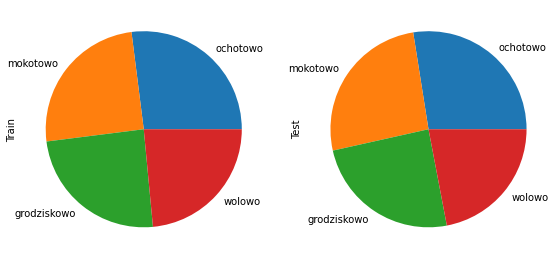

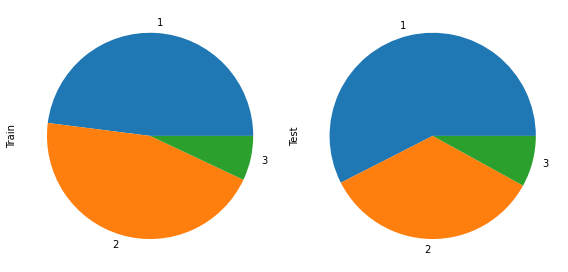

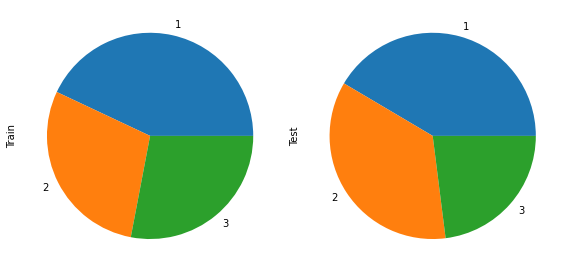

In [ ]:
pies = ['dzielnica', 'ilość_łazienek', 'ilość_sypialni']
for c in pies:
  plot_pie(c)

In [ ]:
from matplotlib import pyplot as plt

def plot_distribution(column):
  dist_train = data[column]
  dist_test = data_test[column]

  fig, ax = plt.subplots()
  dist_train.plot.kde(ax=ax, legend=True, label="Train")
  dist_test.plot.kde(ax=ax, legend=True, label="Test")
  ax.set_ylabel("")
  ax.set_title(column)
  plt.show()

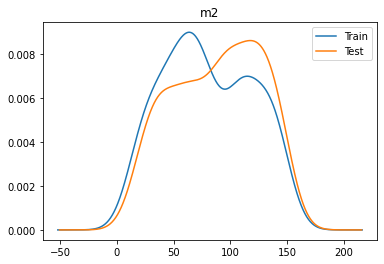

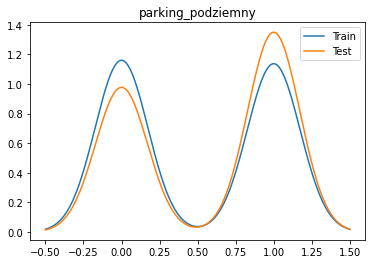

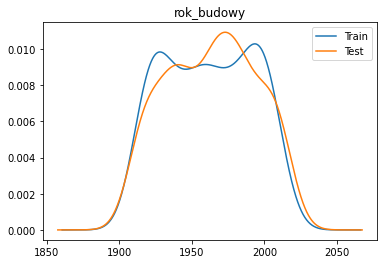

In [ ]:
for c in data.columns.difference(pies + ['cena']):
  plot_distribution(c)